[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/3-nasa.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://nmfs-opensci.github.io/NMFSHackDays-2025/topics-2025/2025-opendap/3-nasa.ipynb
[colab-link]: https://colab.research.google.com/github/nmfs-opensci/nmfshackdays-2025/blob/main/topics-2025/2025-opendap/3-nasa.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/nmfs-opensci/nmfshackdays-2025/main/topics-2025/2025-opendap/3-nasa.ipynb

>📘 Learning Objectives
>
> 1. Show how to work with NASA OPeNDAP for EULA and non-EULA data
> 2. Create a NASA EDL session for authentication
> 3. Load single files with `xarray.open_dataset`
> 4. Load multiple files with `xarray.open_mfdataset`

## Overview

NASA OPeNDAP servers (have nasa.gov in url) require Earthdata Login (EDL) authentication and some require an End User Licence Agreement (EULA). Here is the list of [NASA OPeNDAP servers](https://www.earthdata.nasa.gov/engage/open-data-services-software/earthdata-developer-portal/opendap/servers). There are Hyrax, GraDS and THREDDS servers. They behave slightly differently so it is good to know which one you are using.

In my experience, the NASA OPeNDAP is hard to work with due to the authentication and redirect issues that arise for data that require EULAs and for other unknown reasons. To deal with this, I will show a workflow using `engine="pydap"` and setting up an authenticated session using `earthaccess`. Although you can set up authentication with PyDAP, I find that tends to be fragile and only works consistently if you use an Earthdata token and do not use username/password. `earthaccess` automates the token part for you so you don't have to do that manually. To see how to set up authentication with PyDAP see the extra notebook for that.

BTW, I would try first to find the data on <https://search.earthdata.nasa.gov/search> and try to use `earthaccess` `results` which would point you to the non-opendap cloud links. The `earthaccess` workflow for creating data cubes with `xarray.open_mfdataset` is quite a bit easier with fewer gotchas.

### References

* <https://podaac.jpl.nasa.gov/OPeNDAP-in-the-Cloud>

### Prerequisites

I assume you have a `.netrc` file at `~` (home). `~/.netrc` should look just like this with your username and password. Create that file if needed.

```
machine urs.earthdata.nasa.gov
        login yourusername
        password yourpassword
```


### Packages


In [1]:
import xarray as xr
import pydap.client

## Create a NASA EDL authenticated session

1. Authenticate with `earthaccess.login()` then create the session which will create the right headers when we (or `pydap`) does requests.

In [2]:
import earthaccess
earthaccess.login()
edl_session = earthaccess.get_requests_https_session()

## Example 1: Hyrax server - NO EULA

Let's go to this oceancolor OPeNDAP server <https://oceandata.sci.gsfc.nasa.gov/opendap/>. It is Hyrax, which we can see in the footer. These have both DAP4 and DAP2 protocols. With `pydap`, you can specify `protocol="dap4"` so it knows which one to use. But `xarray.open_dataset()` doesn't accept the `protocol` argument so we need to use a work around.

We dig into the directory to find the PACE-OCI data and then look at the L3SMI directory:
https://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0301/contents.html

We will navigate to the `PACE_OCI.20240301_20240331.L3m.MO.AVW.V3_0.avw.0p1deg.nc` file in `2024/0301`. Here is the url which you will see when you click on the file and get to the "OPeNDAP DAP4 Data Request Form". This a monthly average.
```
url="http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0301/PACE_OCI.20240301_20240331.L3m.MO.AVW.V3_0.avw.0p1deg.nc"
```
But to open with `xarray`, we need to replace the `http` (or `https`) with `dap4`.

### Loading a single file

In [41]:
url="http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0301/PACE_OCI.20240301_20240331.L3m.MO.AVW.V3_0.avw.0p1deg.nc"

dap4_url = url.replace("http", "dap4", 1)
ds = xr.open_dataset(dap4_url, engine="pydap", session=edl_session)
ds

<xarray.Dataset> Size: 26MB
Dimensions:  (/lat: 1800, /lon: 3600, /rgb: 3, /eightbitcolor: 256)
Dimensions without coordinates: /lat, /lon, /rgb, /eightbitcolor
Data variables:
    lat      (/lat) float32 7kB ...
    lon      (/lon) float32 14kB ...
    avw      (/lat, /lon) float32 26MB ...
    palette  (/rgb, /eightbitcolor) uint8 768B ...
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.AVW....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/AVW/3.0
    data_bins:                         Attribute elided: Unsupported attribut...
    data_minimum:                      399.999969
    data_maximum:                      700.000061

We can plot. Note the indices have slashes which we will want to fix and the lat/lon need to be associated with the values in the lat/lon variable, but we are able to create our `xarray` dataset so we can now work with it with standard syntax and clean it up.

Here a do a plot. Note I did not rename the indices to get rid of the slashes, so I have to use dict format for my `.sel` command.

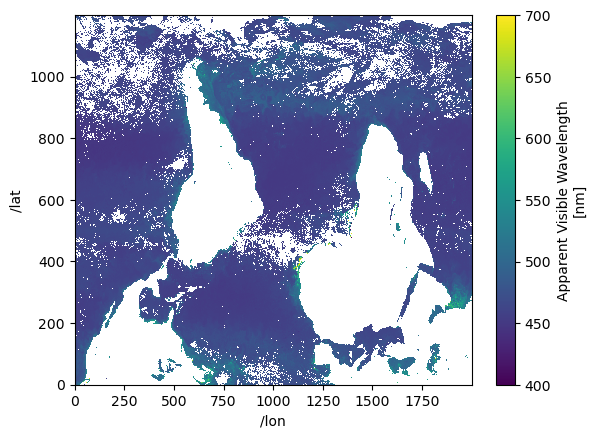

In [45]:
ds["avw"].sel({"/lat": slice(400, 1600), "/lon": slice(500, 2500)}).plot();

### Opening multiple files

Let's combine 3 months.

In [3]:
mar = "http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0301/PACE_OCI.20240301_20240331.L3m.MO.AVW.V3_0.avw.0p1deg.nc"
apr = "http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0401/PACE_OCI.20240401_20240430.L3m.MO.AVW.V3_0.avw.0p1deg.nc"
may = "http://oceandata.sci.gsfc.nasa.gov/opendap/PACE_OCI/L3SMI/2024/0501/PACE_OCI.20240501_20240531.L3m.MO.AVW.V3_0.avw.0p1deg.nc"
urls = [mar, apr, may]

In [4]:
dap4_urls = [url.replace("http", "dap4", 1) for url in urls]
ds = xr.open_mfdataset(
    dap4_urls, engine="pydap",
    combine='nested', concat_dim="/time", 
    session=edl_session)

In [14]:
ds

<xarray.Dataset> Size: 78MB
Dimensions:  (/time: 3, /lat: 1800, /lon: 3600, /rgb: 3, /eightbitcolor: 256)
Dimensions without coordinates: /time, /lat, /lon, /rgb, /eightbitcolor
Data variables:
    lat      (/time, /lat) float32 22kB dask.array<chunksize=(1, 1800), meta=np.ndarray>
    lon      (/time, /lon) float32 43kB dask.array<chunksize=(1, 3600), meta=np.ndarray>
    avw      (/time, /lat, /lon) float32 78MB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    palette  (/time, /rgb, /eightbitcolor) uint8 2kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/62)
    product_name:                      PACE_OCI.20240301_20240331.L3m.MO.AVW....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    cdm_data_type:                     grid
    identifier_product_doi_authority:  http://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/AVW/3.0
    data_bins:                         Attribute elided: Unsupported attribut...
    data_minimum:                      399.999969
    data_maximum:                      700.000061

### Plot mean AVW over all longitudes (global) by latitude and month

In [7]:
lat_mean = ds["avw"].sel({"/lat": slice(400, 1600), "/lon": slice(500, 2500)}).mean(dim=["/lon"])

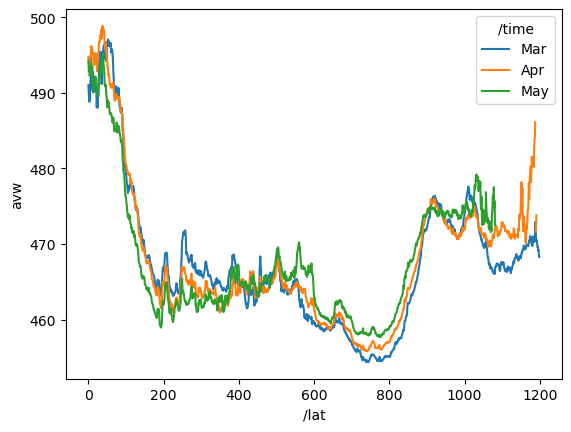

In [21]:
# Define custom labels for each time step
custom_time_labels = ["Mar", "Apr", "May"]  # Adjust based on actual time steps

# Assign new labels to the time coordinate
lat_mean = lat_mean.assign_coords({"/time": custom_time_labels})

# Plot
lat_mean.plot.line(x="/lat");

## Example 2: Get URL via CMR search

We are getting 6 hours of data.

In [3]:
import requests

# Define variables
# Get the concept_id from https://search.earthdata.nasa.gov/
concept_id = "C2036877806-POCLOUD"
start_time = "2022-01-01T00:00:00Z"
end_time = "2022-01-01T06:00:00Z"

# Format the CMR search URL with variables
url = f"https://cmr.earthdata.nasa.gov/search/granules.umm_json?collection_concept_id={concept_id}&temporal={start_time},{end_time}&pageSize=365"

# Make the request
r = requests.get(url)
response_body = r.json()

# Print response status
print(r.status_code)  # Should be 200 if successful

200


Now find the urls with opendap in them. Those are the ones we want.

In [4]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files

['https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101000000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220101_000000-v02.0-fv01.0',
 'https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101010000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220101_010000-v02.0-fv01.0',
 'https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101020000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220101_020000-v02.0-fv01.0',
 'https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101030000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220101_030000-v02.0-fv01.0',
 'https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101040000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-ssteqc_goes16_20220101_040000-v02.0-fv01.0',
 'https://opendap.earthdata.nasa.gov/collections/C2036877806-POCLOUD/granules/20220101050000-OSISAF-L3C_GHRSST-SSTsubskin-GOES16-s

In [5]:
# make sure we have an authenticated session
import earthaccess
earthaccess.login()
edl_session = earthaccess.get_requests_https_session()

Read in the files and combine using the "dap4" replacement again. If you go to <opendap.earthdata.nasa.gov>, you will see that it is Hyrax and we need "dap4" for that. The file complains about decode_cf so I set that.

In [6]:
%%time
dap4_urls = [url.replace("https", "dap4", 1) for url in od_files]
ds = xr.open_mfdataset(
    dap4_urls, engine="pydap",
    combine='nested', concat_dim="/time",
    decode_cf=False,
    session=edl_session)

CPU times: user 750 ms, sys: 61 ms, total: 811 ms
Wall time: 15.4 s


In [7]:
ds

<xarray.Dataset> Size: 1GB
Dimensions:                    (/time: 7, /lon: 2400, /lat: 2400)
Dimensions without coordinates: /time, /lon, /lat
Data variables: (12/19)
    time                       (/time) int32 28B dask.array<chunksize=(1,), meta=np.ndarray>
    lon                        (/time, /lon) float32 67kB dask.array<chunksize=(1, 2400), meta=np.ndarray>
    lat                        (/time, /lat) float32 67kB dask.array<chunksize=(1, 2400), meta=np.ndarray>
    wind_speed                 (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    sses_standard_deviation    (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    sst_dtime                  (/time, /lat, /lon) int32 161MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    ...                         ...
    dt_analysis                (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    satellite_zenith_angle     (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    or_longitude               (/time, /lat, /lon) int16 81MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    adi_dtime_from_sst         (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    or_latitude                (/time, /lat, /lon) int16 81MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
    sses_bias                  (/time, /lat, /lon) int8 40MB dask.array<chunksize=(1, 2400, 2400), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                CF-1.4
    title:                      Sea Surface Temperature
    summary:                    The L3C product derived from GOES16/ABI brigh...
    references:                 Geostationary Sea Surface Temperature Product...
    institution:                OSISAF
    comment:                    None
    ...                         ...
    netcdf_version_id:          4.6.3
    build_dmrpp:                3.20.13-664
    bes:                        3.20.13-664
    libdap:                     libdap-3.20.11-198
    configuration:              \n# TheBESKeys::get_as_config()\nAllowedHosts...
    invocation:                 build_dmrpp -c /tmp/bes_conf_7rdf -f /tmp/tmp...

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


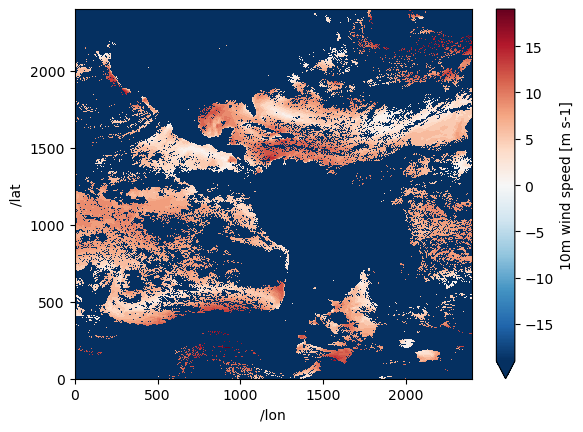

In [8]:
ds["wind_speed"].isel({"/time": 5}).plot();

## Example 3: Data with a EULA - GrADS server

### Prerequisites

Make sure you have the GESDISC EULA accepted.

1. Log into https://urs.earthdata.nasa.gov
2. Then go here https://urs.earthdata.nasa.gov/profile
3. Then click EULAs
4. Go to unaccepted EULAs and make sure that GESDISC is accepted

In [12]:
# the GESDISC data requires a EULA
eula_url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4'

In [13]:
# make sure we have an authenticated session
import earthaccess
earthaccess.login()
edl_session = earthaccess.get_requests_https_session()

In [15]:
# this is NOT Hyrax server. Use the url as is.
ds = xr.open_dataset(eula_url, engine="pydap", session=edl_session)
ds

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 24, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon       (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 192B 2016-06-01T00:30:00 ... 2016-06-01T2...
Data variables: (12/47)
    U2M       (time, lat, lon) float64 40MB ...
    V250      (time, lat, lon) float64 40MB ...
    TROPT     (time, lat, lon) float64 40MB ...
    TROPPB    (time, lat, lon) float64 40MB ...
    T2M       (time, lat, lon) float64 40MB ...
    TQL       (time, lat, lon) float64 40MB ...
    ...        ...
    TROPPV    (time, lat, lon) float64 40MB ...
    H500      (time, lat, lon) float64 40MB ...
    V500      (time, lat, lon) float64 40MB ...
    T2MWET    (time, lat, lon) float64 40MB ...
    U500      (time, lat, lon) float64 40MB ...
    QV10M     (time, lat, lon) float64 40MB ...
Attributes: (12/31)
    DODS_EXTRA.Unlimited_Dimension:    time
    History:                           Original file generated: Tue Jun 14 18...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2016-06-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2016-06-01
    RangeEndingTime:                   23:59:59.000000

Getting `ds` did not get the data. So wouldn't run into the EULA problem. But once we try to plot, we would run into the EULA. If we didn't not have it accepted, it would not let us read the data. But even if it were accepted, it can be tricky to get past re-directs. Fortunately the `earthaccess` authenticated session works well as it gets the EDL token for us automatically.

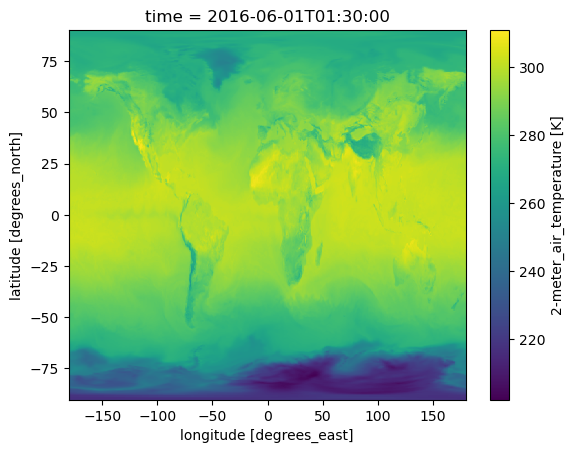

In [16]:
ds["T2M"].isel(time=1).plot();

### Creating data cubes

Data cubes with data that have EULA often goes south (re-directs) but with `earthaccess` authenticated sessions it works well.

In [17]:
eula_url1 = 'dap4://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4'
eula_url2 = 'dap4://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXSLV.5.12.4/2016/06/MERRA2_400.tavg1_2d_slv_Nx.20160602.nc4'
eula_urls = [eula_url1, eula_url2]

In [19]:
%%time
import xarray as xr
# very fast and this is 1Tb of data
ds = xr.open_mfdataset(eula_urls, engine="pydap", 
                       combine="nested", concat_dim="/time", 
                       decode_cf=False, session=edl_session)
ds

CPU times: user 141 ms, sys: 12.2 ms, total: 153 ms
Wall time: 6.54 s


<xarray.Dataset> Size: 2GB
Dimensions:   (/time: 48, /lat: 361, /lon: 576)
Dimensions without coordinates: /time, /lat, /lon
Data variables: (12/50)
    U2M       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    V250      (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TROPT     (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TROPPB    (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    T2M       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TQL       (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    ...        ...
    T2MWET    (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    U500      (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    QV10M     (/time, /lat, /lon) float32 40MB dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    lat       (/time, /lat) float64 139kB dask.array<chunksize=(24, 361), meta=np.ndarray>
    lon       (/time, /lon) float64 221kB dask.array<chunksize=(24, 576), meta=np.ndarray>
    time      (/time) int32 192B dask.array<chunksize=(24,), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Tue Jun 14 18...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20160601.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2016-06-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2016-06-01
    RangeEndingTime:                   23:59:59.000000
    Unlimited_Dimension:               time

In [20]:
print(f"Dataset size: {ds.nbytes/1e6:.2f} MB")

Dataset size: 1876.77 MB


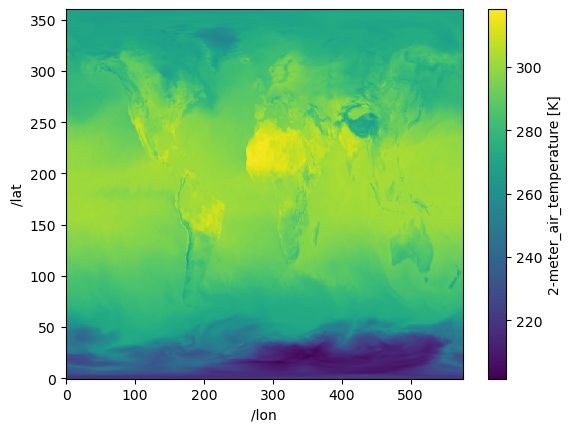

In [23]:
ds["T2M"].isel({"/time": 40}).plot();

## Example 4 Using constraint expresions

In this example from the pydap documentation, constraint expression is used just to get certain variables when the OPeNDAP server uses Hyrax. See full notebook [here](https://pydap.github.io/pydap/notebooks/ECCO.html#add-a-constraint-expression-to-the-url-to-only-retrieve-theta).  Using the constraint expression can greatly speed up the data access.

In [24]:
baseURL = 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/'
Temp_Salt = "ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_"
year = '2017-'
month = '01'
end_ = '_ECCO_V4r4_native_llc0090'
CE = '?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time'

Temp_2017 = [baseURL + Temp_Salt + year + f'{i:02}' + end_ + CE for i in range(1, 4)]
Temp_2017

['dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-01_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-02_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time',
 'dap4://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/ECCO%20Ocean%20Temperature%20and%20Salinity%20-%20Monthly%20Mean%20llc90%20Grid%20(Version%204%20Release%204)/granules/OCEAN_TEMPERATURE_SALINITY_mon_mean_2017-03_ECCO_V4r4_native_llc0090?dap4.ce=/THETA;/SALT;/tile;/j;/k;/i;/time']

Create data cube with `open_mfdataset` but not concat dim is `/time` not `time`. This takes a really long time, but if we didn't do the constraint expression part, it would take much longer. So it is good to do that step.

In [25]:
%%time
# 13 seconds to assemble the data cube for a 126Mb dataset...slow
theta_salt_ds = xr.open_mfdataset(
    Temp_2017, 
    engine='pydap',
    parallel=True, 
    combine='nested', 
    concat_dim='/time',
    session=edl_session
)
theta_salt_ds

CPU times: user 173 ms, sys: 13.2 ms, total: 187 ms
Wall time: 13.4 s


<xarray.Dataset> Size: 126MB
Dimensions:  (/time: 3, /k: 50, /tile: 13, /j: 90, /i: 90)
Coordinates:
    time     (/time) datetime64[ns] 24B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: /time, /k, /tile, /j, /i
Data variables:
    SALT     (/time, /k, /tile, /j, /i) float32 63MB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    THETA    (/time, /k, /tile, /j, /i) float32 63MB dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    i        (/time, /i) int32 1kB dask.array<chunksize=(1, 90), meta=np.ndarray>
    j        (/time, /j) int32 1kB dask.array<chunksize=(1, 90), meta=np.ndarray>
    k        (/time, /k) int32 600B dask.array<chunksize=(1, 50), meta=np.ndarray>
    tile     (/time, /tile) int32 156B dask.array<chunksize=(1, 13), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2017-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2017-01-01T00:00:00
    title:                           ECCO Ocean Temperature and Salinity - Mo...
    uuid:                            f5b7028c-4181-11eb-b7e6-0cc47a3f47b1

In [94]:
print(f"Dataset size: {theta_salt_ds.nbytes/1e6:.2f} MB")

Dataset size: 126.36 MB


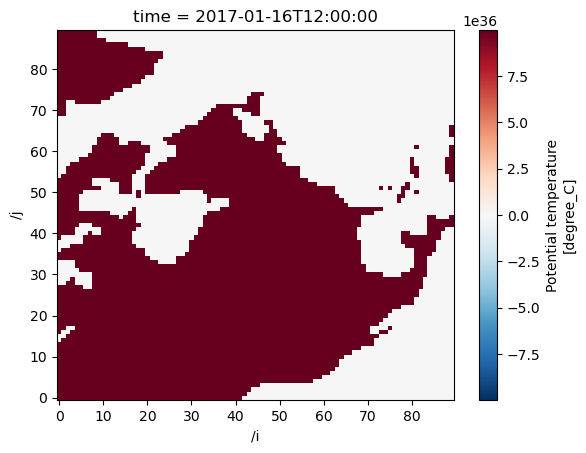

In [26]:
theta_salt_ds["THETA"].isel({"/time":0, "/tile":10, "/k":1}).plot();

## Conclusion

Working with NASA OPeNDAP servers using the `earthaccess` authenticated sessions, makes it easier to using xarray for single and multiple files.

## References

* https://pydap.github.io/pydap/intro.html
* https://opendap.github.io/documentation/tutorials/ClientAuthentication.html#_pydap
* https://github.com/OPENDAP/NASA-tutorials/tree/main

